In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загружаем данные
data = pd.read_csv('/content/drive/MyDrive/SBER_000101_230101.csv', delimiter = ',')
data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,M,01/01/00,0,1150.00,1543.00,1080.0,1137.0,728136
1,SBER,M,01/02/00,0,1160.00,1447.00,1117.0,1348.0,537210
2,SBER,M,01/03/00,0,1385.00,1637.01,1320.0,1420.0,910994
3,SBER,M,01/04/00,0,1422.00,1573.00,1350.0,1486.5,684935
4,SBER,M,01/05/00,0,1471.55,1501.00,860.0,1130.0,295793


In [ ]:
# Удаляем столбцы, кроме цены закрытия
data.drop(["<TICKER>", "<PER>", "<TIME>", "<OPEN>", "<HIGH>", "<LOW>", "<VOL>"], axis=1, inplace=True)

In [ ]:
data = data.rename(columns={'<DATE>': 'date','<CLOSE>': 'close'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

In [ ]:
data.head(10)

,close
date,
2000-01-01,1137.00
2000-01-02,1348.00
2000-01-03,1420.00
2000-01-04,1486.50
2000-01-05,1130.00
2000-01-06,975.00
2000-01-07,1310.00
2000-01-08,1403.05
2000-01-09,1153.00


In [ ]:
# Преобразуем данные в массив numpy
dataset = data.values

In [ ]:
# Преобразуем данные в формат, пригодный для обучения модели LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(dataset) * 0.7) # 70% данных для обучения
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# Создание матрицы признаков и матрицы целевых переменных
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Используем шаг 12 (12 месяцев) для создания матриц признаков и целевых переменных
look_back = 12
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [ ]:
# Изменение формы признаков
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
180/180 - 3s - loss: 0.0305 - 3s/epoch - 14ms/step
Epoch 2/100
180/180 - 1s - loss: 0.0190 - 634ms/epoch - 4ms/step
Epoch 3/100
180/180 - 1s - loss: 0.0160 - 659ms/epoch - 4ms/step
Epoch 4/100
180/180 - 1s - loss: 0.0134 - 660ms/epoch - 4ms/step
Epoch 5/100
180/180 - 1s - loss: 0.0118 - 651ms/epoch - 4ms/step
Epoch 6/100
180/180 - 1s - loss: 0.0106 - 674ms/epoch - 4ms/step
Epoch 7/100
180/180 - 1s - loss: 0.0089 - 626ms/epoch - 3ms/step
Epoch 8/100
180/180 - 1s - loss: 0.0082 - 616ms/epoch - 3ms/step
Epoch 9/100
180/180 - 1s - loss: 0.0076 - 648ms/epoch - 4ms/step
Epoch 10/100
180/180 - 1s - loss: 0.0065 - 795ms/epoch - 4ms/step
Epoch 11/100
180/180 - 1s - loss: 0.0070 - 932ms/epoch - 5ms/step
Epoch 12/100
180/180 - 1s - loss: 0.0057 - 871ms/epoch - 5ms/step
Epoch 13/100
180/180 - 1s - loss: 0.0054 - 954ms/epoch - 5ms/step
Epoch 14/100
180/180 - 1s - loss: 0.0089 - 870ms/epoch - 5ms/step
Epoch 15/100
180/180 - 1s - loss: 0.0057 - 647ms/epoch - 4ms/step
Epoch 16/100
180/180 

In [ ]:
# Прогнозирование с использованием модели LSTM
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


In [ ]:
# Обратное преобразование для сравнения с исходными данными
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Строим график обучения и прогнозирования
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

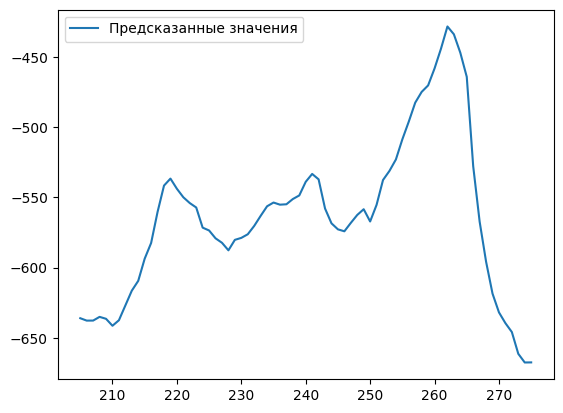

In [ ]:
plt.plot(testPredictPlot, label='Предсказанные значения')
plt.legend()
plt.show()

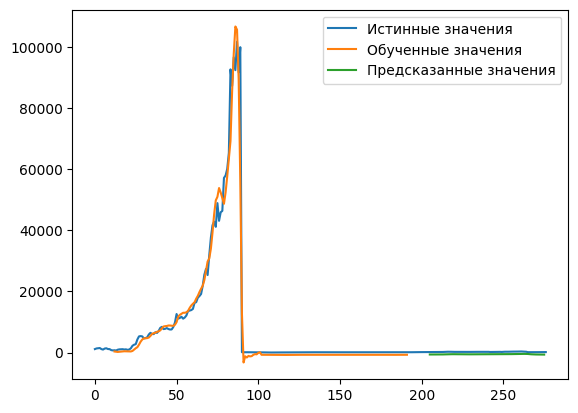

In [ ]:
plt.plot(scaler.inverse_transform(dataset), label='Истинные значения')
plt.plot(trainPredictPlot, label = 'Обученные значения')
plt.plot(testPredictPlot, label='Предсказанные значения')
plt.legend()
plt.show()

Метод экспонициального сглаживания

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Обучение модели на исторических данных
model = ExponentialSmoothing(data['close'], trend='additive', seasonal='multiplicative', seasonal_periods=12)
fit = model.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
pred = fit.forecast(36)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


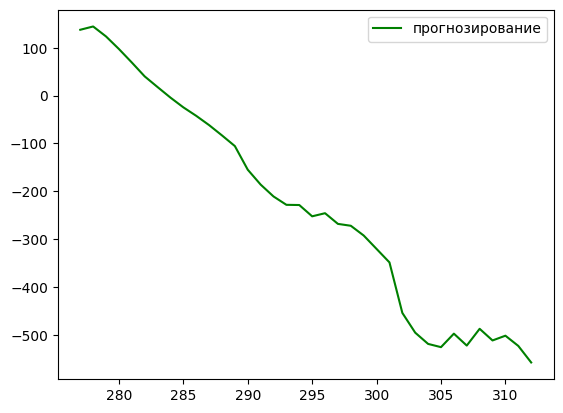

In [ ]:
plt.plot(pred, label = 'прогнозирование', color = 'green')
plt.legend()
plt.show()

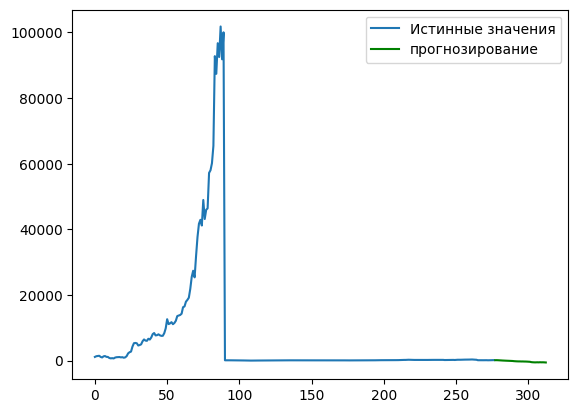

In [ ]:
plt.plot(scaler.inverse_transform(dataset), label='Истинные значения')
plt.plot(pred, label = 'прогнозирование', color = 'green')
plt.legend()
plt.show()

Модель SARIMAX

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


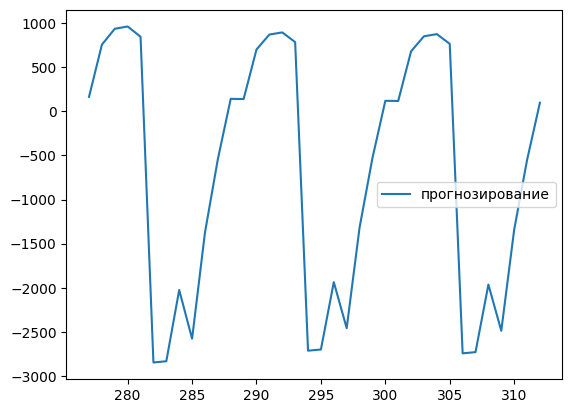

In [ ]:
#модель SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Обучение модели на исторических данных
model_2 = SARIMAX(data['close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_2 = model_2.fit()

# Прогнозирование значений на 3 года вперед
pred_2 = fit_2.forecast(36)

plt.plot(pred_2, label = 'прогнозирование')
plt.legend()
plt.show()

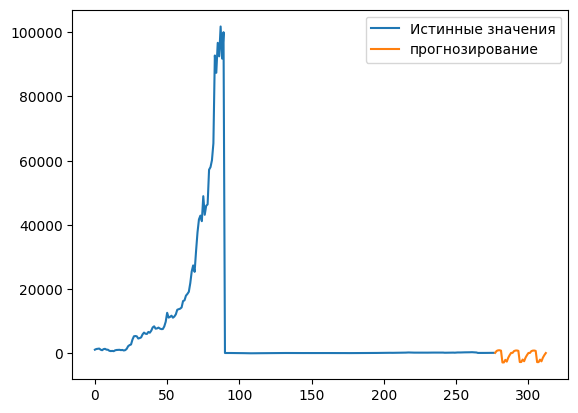

In [ ]:
plt.plot(scaler.inverse_transform(dataset), label='Истинные значения')
plt.plot(pred_2, label = 'прогнозирование')
plt.legend()
plt.show()

Создание нового параметра - AVG. Построение модели LTSM

In [ ]:
#загрузка данных
data = pd.read_csv('/content/drive/MyDrive/SBER_000101_230101.csv', delimiter=',')

In [ ]:
#переименование и сортирование столбцов 
data = data.rename(columns={'<DATE>': 'date', '<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'volume'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

In [ ]:
#создание новой переменной
data['avg'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4

In [ ]:
#нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data[['avg']])

In [ ]:
#создание функции для обучающей выборки 
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
#разделение на обучающую и тестовую
train_size = int(len(data_normalized) * 0.70)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]
print('Train size:', len(train))
print('Test size:', len(test))

Train size: 193
Test size: 84


In [ ]:
#создание обучающей и тестовой 
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
181/181 - 2s - loss: 0.0285 - 2s/epoch - 14ms/step
Epoch 2/100
181/181 - 1s - loss: 0.0196 - 733ms/epoch - 4ms/step
Epoch 3/100
181/181 - 1s - loss: 0.0157 - 760ms/epoch - 4ms/step
Epoch 4/100
181/181 - 1s - loss: 0.0136 - 758ms/epoch - 4ms/step
Epoch 5/100
181/181 - 1s - loss: 0.0106 - 784ms/epoch - 4ms/step
Epoch 6/100
181/181 - 1s - loss: 0.0097 - 749ms/epoch - 4ms/step
Epoch 7/100
181/181 - 1s - loss: 0.0078 - 757ms/epoch - 4ms/step
Epoch 8/100
181/181 - 1s - loss: 0.0044 - 773ms/epoch - 4ms/step
Epoch 9/100
181/181 - 1s - loss: 0.0065 - 752ms/epoch - 4ms/step
Epoch 10/100
181/181 - 1s - loss: 0.0055 - 793ms/epoch - 4ms/step
Epoch 11/100
181/181 - 1s - loss: 0.0048 - 1000ms/epoch - 6ms/step
Epoch 12/100
181/181 - 1s - loss: 0.0045 - 1s/epoch - 6ms/step
Epoch 13/100
181/181 - 1s - loss: 0.0041 - 1s/epoch - 6ms/step
Epoch 14/100
181/181 - 1s - loss: 0.0038 - 1s/epoch - 6ms/step
Epoch 15/100
181/181 - 1s - loss: 0.0041 - 813ms/epoch - 4ms/step
Epoch 16/100
181/181 - 1s - l

In [ ]:
#прогнозирование значений 
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

3/3 [==============================] - 0s 5ms/step


In [ ]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

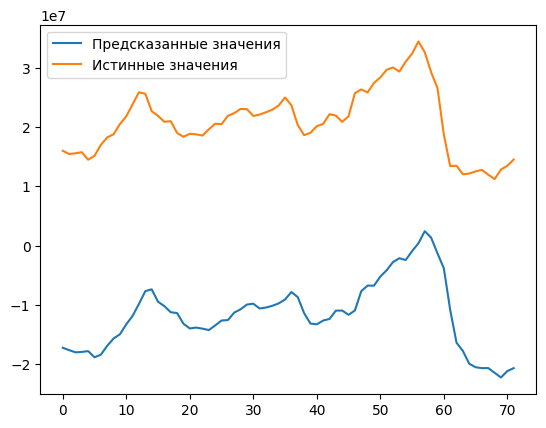

In [ ]:
#строим графики
plt.plot(testPredict, label='Предсказанные значения')
plt.plot(testY, label='Истинные значения')
plt.legend()
plt.show()

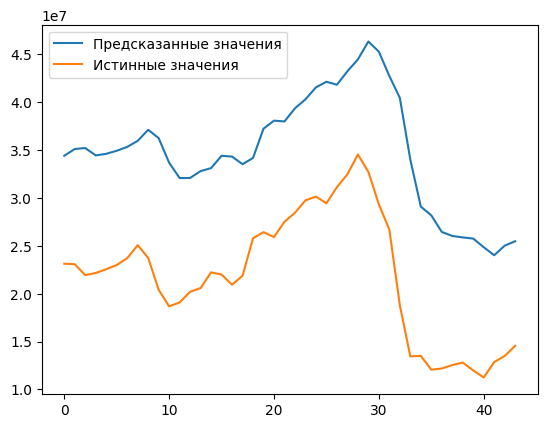

In [ ]:
plt.plot(testPredict, label='Предсказанные значения')
plt.plot(testY, label='Истинные значения')
plt.legend()
plt.show()